In [1]:
# setup
from planet4 import clustering, markings, io
data = {'x':[210,211,212], 'y':[100,102, 104], 'image_x':[10000,10001,10002], 
        'image_y':[20000,20001,20002],
        'angle':[34, 37,40], 'radius_1':[20,21,19], 'radius_2':[50,51,52]}
three_blotches_data = pd.DataFrame(data)
blotch = markings.Blotch(three_blotches_data.iloc[0])

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [55]:
# test_calc_fnotch
actual = clustering.calc_fnotch(4, 4)
assert actual == 0.5
actual = clustering.calc_fnotch(4, 0)
assert actual == 1
actual = clustering.calc_fnotch(0, 4)
assert actual == 0

In [56]:
# test_simple_blotch_clustering
dbscanner = clustering.DBScanner(three_blotches_data, 'blotch', scope='hirise')
cdata = dbscanner.reduced_data[0].data
assert cdata.x == 10001
assert cdata.y == 20001
assert cdata.angle == 37
assert cdata.radius_1 == 20
assert cdata.radius_2 == 51

/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


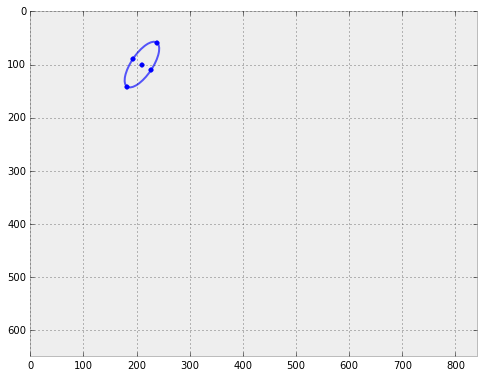

In [13]:
%matplotlib inline
from itertools import cycle
colors = cycle('rgbcym')

fig, ax = plt.subplots(figsize = markings.calc_fig_size(8))
blotch = markings.Blotch(three_blotches_data.iloc[0])

blotches = [blotch]
ax.add_artist(blotch)
markings.set_subframe_size(ax)
blotch.plot_center(ax)
# ax.set_axis_off()
blotch.plot_limit_points(ax)

In [33]:
p4id = markings.example_p4id()

/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


3
3

/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)



4

/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)



4

/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)



4

/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)



3


/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


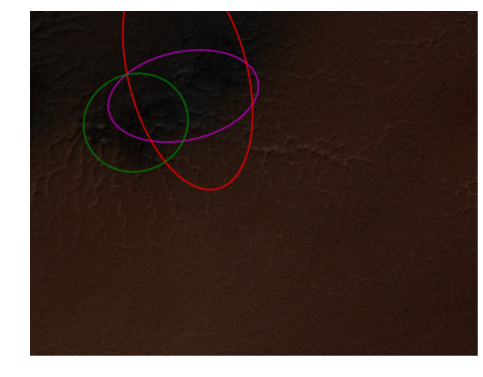

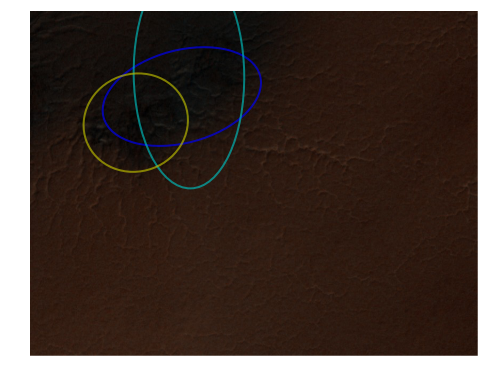

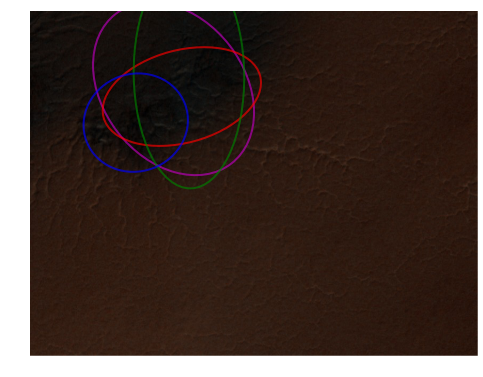

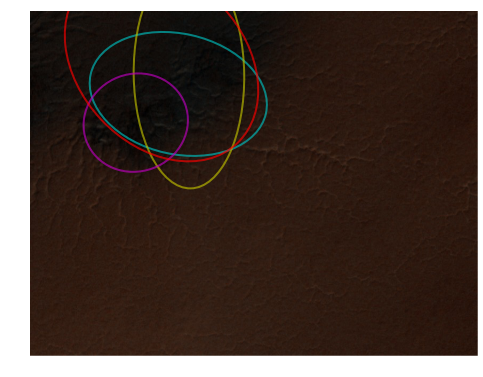

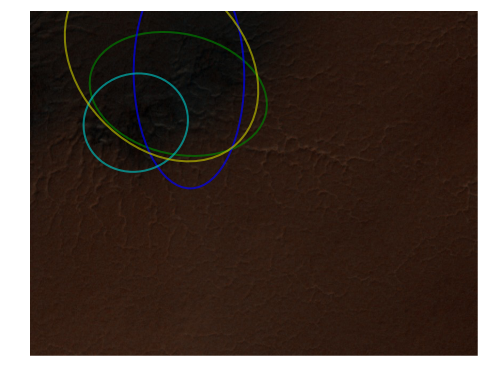

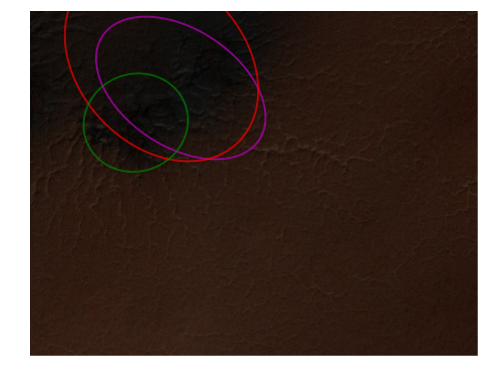

In [53]:
for eps in range(10,16):
    cm = clustering.ClusteringManager(scope='planet4', eps=eps)
    cm.cluster_image_id(p4id.imgid)
    cm.plot_image_id_blotches()
    print(cm.n_clustered_blotches)

In [52]:
cm.n_clustered_blotches

0

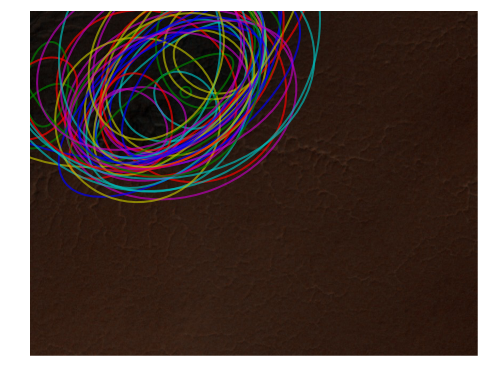

In [47]:
p4id.plot_blotches()